<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.0 MB/s eta 0:00:00


Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [5]:
# Загрузим датасет
dataset = load_dataset('imdb')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

Посмотрим как выглядит типичный текст

In [6]:
text_example = dataset['train']['text'][0]
print(text_example)

I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, eve

Размеры датасетов

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

#### Разделение текста на предложения

Разобьём его на предложения и очистим эти предложения от html тэгов

In [8]:
import re
import os
import string

def remove_html_tags(text):
    return re.sub(r'<[^>]*>', ' ', text)

def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

def remove_extra_spaces(text):
    return re.sub(r'\s+', ' ', text)

In [9]:
sentnce_examples = sent_tokenize(text_example, language='english')
print("N sentences =", len(sentnce_examples))

for s in sentnce_examples:
    print('-'*50)
    print(s)
    print(remove_html_tags(s))

N sentences = 9
--------------------------------------------------
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967.
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967.
--------------------------------------------------
I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life.
I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.  The plot is centered around a young Swedish drama student named Lena who wants to learn everythin

#### Разделение предложений на слова

Разобьём эти предложения на слова

In [10]:
for s in sentnce_examples[:10]:
    print(s)
    sent = word_tokenize(remove_html_tags(s), language='english')
    sent = [i.lower() for i in sent if not i in string.punctuation]
    new_s = remove_extra_spaces(remove_punctuation(" ".join(sent)))
    new_s = " ".join(sent_tokenize(new_s))
    print(new_s)
    print('-'*50)

I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967.
i rented i am curiousyellow from my video store because of all the controversy that surrounded it when it was first released in 1967
--------------------------------------------------
I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life.
i also heard that at first it was seized by us customs if it ever tried to enter this country therefore being a fan of films considered controversial i really had to see this for myself the plot is centered around a young swedish drama student named lena who wants to learn everything she can about life
--------------------------------------------------
In p

#### Очистка массивов слов

Возьмём все 3 датасета IMDB, чтобы получить выборку максимального размера

* Удаление пунктуации
* Удаление html разметки
* Удаление редко встречающихся слов
* Оставляем только предлодения, в которых менее 32 слов

In [11]:
dataset.keys()

dict_keys(['train', 'test', 'unsupervised'])

Тут много лишних действий, не образайте внимания, торопился слегка

In [12]:
sentences = []
word_threshold = 32

for k in dataset.keys():
    print(k)
    for text in tqdm(dataset[k]['text']):
        text_sentences = sent_tokenize(text, language='english')
        for s in text_sentences:
            #
            sent = word_tokenize(remove_html_tags(s), language='english')
            sent = [i.lower() for i in sent if not i in string.punctuation]
            new_sent = remove_extra_spaces(remove_punctuation(" ".join(sent)))
            new_sent = " ".join(sent_tokenize(new_sent))
            #
            words = word_tokenize(new_sent, language='english')
            words = [word.lower() for word in words if not word in string.punctuation]
            s_no_punct = " ".join(words)
            n_words = len(words)
            if n_words < word_threshold:
                sentences.append(s_no_punct)

train


  0%|          | 0/25000 [00:00<?, ?it/s]

test


  0%|          | 0/25000 [00:00<?, ?it/s]

unsupervised


  0%|          | 0/50000 [00:00<?, ?it/s]

In [13]:
# Предложение, которое изначально было с пунктуацией и разметкой
print(len(word_tokenize(sentences[0], language='english')))

for s in sentences[:10]:
    print(s)
    print('-'*10)

24
i rented i am curiousyellow from my video store because of all the controversy that surrounded it when it was first released in 1967
----------
really the sex and nudity scenes are few and far between even then it s not shot like some cheaply made porno
----------
while my countrymen mind find it shocking in reality sex and nudity are a major staple in swedish cinema
----------
i am curiousyellow is a good film for anyone wanting to study the meat and potatoes no pun intended of swedish cinema
----------
but really this film does nt have much of a plot
----------
i am curious yellow is a risible and pretentious steaming pile
----------
it does nt matter what one s political views are because this film can hardly be taken seriously on any level
----------
as for the claim that frontal male nudity is an automatic nc17 that is nt true
----------
i ve seen rrated films with male nudity
----------
granted they only offer some fleeting views but where are the rrated films with gaping vulv

In [14]:
print("Всего предложений:", len(sentences))

Всего предложений: 867532


#### Встречаемость слов

Посчитаем для каждого слова его встречаемость.

In [15]:
words = Counter()

for sentence in tqdm(sentences):
    for word in word_tokenize(sentence, language='english'):
        words[word] += 1

  0%|          | 0/867532 [00:00<?, ?it/s]

In [16]:
words['between']

6827

In [17]:
print(f"Всего слов встретилось: {len(words)}")

Всего слов встретилось: 143128


In [18]:
for w, c in words.most_common(10):
    print(w, c, sep=' -> ')

the -> 733248
a -> 360711
and -> 352585
of -> 305963
to -> 289705
is -> 268499
it -> 239561
i -> 225206
in -> 199579
this -> 196986


#### Исключение редких слов

Добавим в словарь ```vocab_size``` самых встречающихся слов. По сути на этом этапе мы убираем из словаря редко встречающиеся слова

In [19]:
words.most_common()[40000]

('suggestively', 5)

In [20]:
len(words.most_common())

143128

Число 40 тысяч выбрано потому, что примерно в этом диапазоне индексов слова начинают встречаться менее 5 раз. Возможно, имеет смысл поварьировать данный порог

In [21]:
most_common_words = words.most_common()

min_counts = 3

for i in range(len(most_common_words)):
    if most_common_words[i][1] < min_counts:
        print(i)
        break

56688


In [22]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000

# Наполнение словаря
for word, cnt in words.most_common(vocab_size):
    vocab.add(word)

In [23]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [24]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [25]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [26]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = []
        tokenized_sentence += [self.bos_id]
        for word in word_tokenize(self.data[idx], language='english'):
            if word in word2ind.keys():
                tokenized_sentence.append(word2ind[word])
            else:
                tokenized_sentence.append(self.unk_id)
        tokenized_sentence += [self.eos_id]
        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [27]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        # паддинг до самой длинной послдеовательности в батче
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    # Токены "target_ids" - это следующие токены относительно "input_ids"
    # То есть
    # target_ids[n_batch, i] = input_ids[n_batch, i+1]
    new_batch = {
        # все токены, не включая последний
        'input_ids': sequences[:,:-1],
        # все токены, смещённые на 1 влево
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [28]:
RANDOM_STATE = 13

train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2, random_state=RANDOM_STATE)
eval_sentences, test_sentences = train_test_split(eval_sentences, test_size=0.5, random_state=RANDOM_STATE)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

print(f"Whole number of sentences = {len(sentences)}")
print(f"train dataset length = {len(train_dataset)}")
print(f"eval dataset length = {len(eval_dataset)}")
print(f"test dataset length = {len(test_dataset)}")

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

Whole number of sentences = 867532
train dataset length = 694025
eval dataset length = 86753
test dataset length = 86754


In [29]:
test_idx = 20

for i in train_dataset[test_idx]:
    print(ind2word[i], end=' ')

print()
print(train_sentences[test_idx])

<bos> check out <unk> disco mein <unk> <unk> and the title track do not go looking for any logic since it is a comedy and the screenplay is of convenience completely <eos> 
check out kisi disco mein jaayen makhna and the title track do not go looking for any logic since it is a comedy and the screenplay is of convenience completely


#### Проверка dataloader

In [30]:
input_ids_test = next(iter(train_dataloader))['input_ids']
target_ids_test = next(iter(train_dataloader))['target_ids']

In [31]:
input_ids_test.shape

torch.Size([128, 32])

In [32]:
" ".join(ind2word[int(i)] for i in input_ids_test[0])

'<bos> turner s part is so small and pointless but she still manages to appear lost on screen <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>'

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [33]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    losses = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            losses.append(loss)
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)
    losses_mean = sum(losses) / len(losses)

    return losses_mean, perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [34]:
import os

SAVE_DIR = "./saved_models/"
os.makedirs(SAVE_DIR, exist_ok=True)

In [35]:
def train_model(model, criterion, optimizer, num_epoch,
                train_data, eval_data, save_dir = SAVE_DIR, model_name = "default"):
    train_losses = []
    train_perplexities = []

    eval_losses = []
    eval_perplexities = []

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for batch in tqdm(train_data, desc=f'Training epoch {epoch}:'):
            input, labels = batch["input_ids"].to(device), batch["target_ids"].to(device)
            optimizer.zero_grad()
            logits = model(input).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, labels.flatten())
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        train_losses.append(sum(epoch_losses) / len(epoch_losses))
        _, train_perp = evaluate(model, criterion, train_data)
        train_perplexities.append(train_perp)
        print(f"Train loss = {sum(epoch_losses) / len(epoch_losses)}")
        print(f"Train perplexity = {train_perp}")

        eval_loss, eval_perp = evaluate(model, criterion, eval_data)
        eval_losses.append(eval_loss)
        eval_perplexities.append(eval_perp)
        print(f"Eval loss = {eval_loss}")
        print(f"Eval perplexity = {eval_perp}")

        model_path = os.path.join(save_dir, f"{model_name}_epoch_{epoch}.pt")
        torch.save(model.state_dict(), model_path)

    return train_losses, train_perplexities, eval_losses, eval_perplexities

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

**Архитектура сети для 1-го теста**

* Размерность эмбеддинга - 196
* Скрытый слой: GRU (1 слой) размерности 128, ф-ция активации tanh
* Полносвязный слой, размерность 128, ф-ция активации ReLU
* Слой проекции на словарь

Оптимизатор - Adam

In [36]:
train_losses = {}
train_peprlexities = {}
eval_losses = {}
eval_peprlexities = {}

In [37]:
class GRULanguageModel(nn.Module):
    def __init__(self, embedding_dim: int, hidden_dim: int, vocab_size: int,
                 num_rnn_layers: int = 1,
                 dropout_rate: float = 0.1):
        super().__init__()
        # Эмбеддинг слова - по индексу слова сопоставляет ему вектор
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Рекурентный блок (GRU)
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_rnn_layers, batch_first=True)

        # Линейный слой
        self.linear = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        # Линейный слой для проекции на словарь
        self.projection = nn.Linear(in_features=hidden_dim, out_features=vocab_size)

        self.non_lin_tanh = nn.Tanh()
        self.non_lin_relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # Эмбеддинг слова из вектора размерности словаря
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, embedding_dim]
        # output - скрытые состояния GRU слоя для данного слова
        # hidden_dim - размерность скрытого состояния GRU
        output, _ = self.gru(embeddings)  # [batch_size, seq_len, hidden_dim]
        # * tanh после GRU
        # * полносвязный слой
        # * dropout
        output = self.dropout(self.linear(self.non_lin_tanh(output)))  # [batch_size, seq_len, hidden_dim]
        # Проекция на словарь
        projection = self.projection(self.non_lin_relu(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [ ]:
model = GRULanguageModel(embedding_dim=128, hidden_dim=128, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
name = "model_1"

train_losses[name], train_peprlexities[name], eval_losses[name], eval_peprlexities[name] = \
    train_model(model, criterion, optimizer, 5, train_dataloader, eval_dataloader, model_name=name)

Training epoch 0::   0%|          | 0/5423 [00:00<?, ?it/s]

Train loss = 5.56516912347075
Train perplexity = 175.4195270344887
Eval loss = 5.223726272583008
Eval perplexity = 186.43408524954916


Training epoch 1::   0%|          | 0/5423 [00:00<?, ?it/s]

Train loss = 5.144336429882946
Train perplexity = 145.2516144476934
Eval loss = 5.090296745300293
Eval perplexity = 163.15090693696058


Training epoch 2::   0%|          | 0/5423 [00:00<?, ?it/s]

Train loss = 5.017457639337927
Train perplexity = 132.107457032398
Eval loss = 5.047650337219238
Eval perplexity = 156.3641172425937


Training epoch 3::   0%|          | 0/5423 [00:00<?, ?it/s]

Train loss = 4.944620073182368
Train perplexity = 124.50864075990086
Eval loss = 5.034981727600098
Eval perplexity = 154.43476147496946


Training epoch 4::   0%|          | 0/5423 [00:00<?, ?it/s]

Train loss = 4.89592180281971
Train perplexity = 119.51286601650963
Eval loss = 5.033511161804199
Eval perplexity = 154.2470983319578


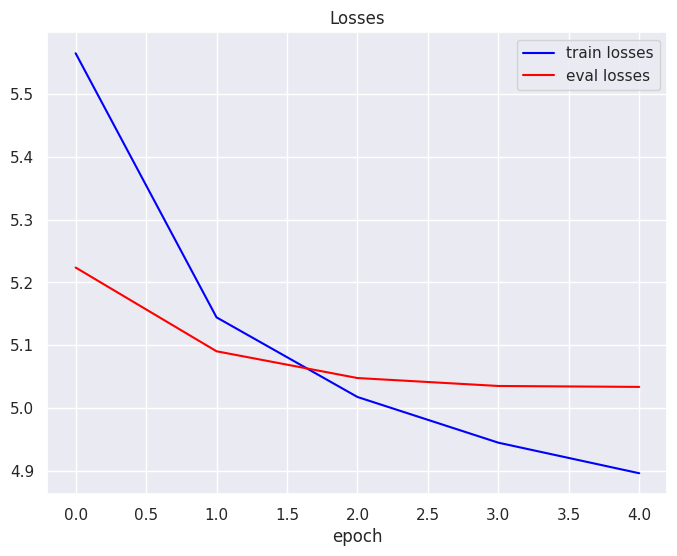

In [ ]:
plt.figure(figsize=(8, 6))

eval_losses[name] = [i.cpu() for i in eval_losses[name]]

n_epochs = len(eval_losses[name])
plt.plot(np.arange(n_epochs), train_losses[name], label='train losses', c='blue')
plt.plot(np.arange(n_epochs), eval_losses[name], label='eval losses', c='red')
plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

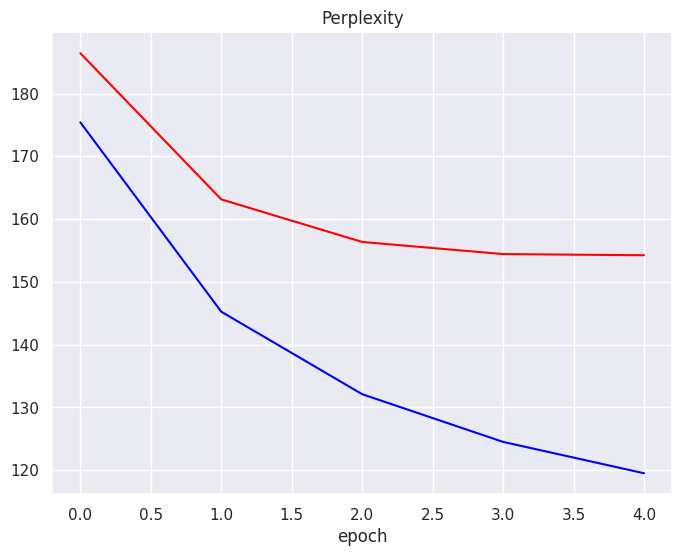

In [ ]:
plt.figure(figsize=(8, 6))

n_epochs = len(eval_peprlexities[name])
plt.plot(np.arange(n_epochs), train_peprlexities[name], label='train perplexity', c='blue')
plt.plot(np.arange(n_epochs), eval_peprlexities[name], label='eval perplexity', c='red')
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

#### Перплексия на тестовой выборке

Загрузим веса не с послдней эпохи, так как там пошло переобучение

In [ ]:
path = SAVE_DIR + "/model_1_epoch_5.pt"
model.load_state_dict(torch.load(path, weights_only=True))

<All keys matched successfully>

In [ ]:
evaluate(model, criterion, test_dataloader)

(tensor(5.0400, device='cuda:0'), 155.32945226708696)

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

Во вотором эксперименте использую LSTM слой и увеличу размер embedding слоя до 256.

In [38]:
class RNNLanguageModel(nn.Module):
    def __init__(self, embedding_dim: int, hidden_dim: int, vocab_size: int,
                 num_rnn_layers: int = 1, dropout_rate: float = 0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM слой, 2
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.projection = nn.Linear(in_features=hidden_dim, out_features=vocab_size)

        self.non_lin_tanh = nn.Tanh()
        self.non_lin_relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.lstm(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin_tanh(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin_relu(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [39]:
model2 = RNNLanguageModel(embedding_dim=256, hidden_dim=128, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model2.parameters())

In [40]:
name = "model_2"

train_losses[name], train_peprlexities[name], eval_losses[name], eval_peprlexities[name] = \
    train_model(model2, criterion, optimizer, 5, train_dataloader, eval_dataloader, model_name=name)

Training epoch 0::   0%|          | 0/5423 [00:00<?, ?it/s]

Train loss = 5.747045655279566
Train perplexity = 197.62020912852736
Eval loss = 5.321773052215576
Eval perplexity = 205.58022891244354


Training epoch 1::   0%|          | 0/5423 [00:00<?, ?it/s]

Train loss = 5.226687712091681
Train perplexity = 155.54869348440533
Eval loss = 5.12235164642334
Eval perplexity = 168.44161730740979


Training epoch 2::   0%|          | 0/5423 [00:00<?, ?it/s]

Train loss = 5.0665810157864515
Train perplexity = 137.49580257527617
Eval loss = 5.039334297180176
Eval perplexity = 155.03653314190979


Training epoch 3::   0%|          | 0/5423 [00:00<?, ?it/s]

Train loss = 4.974000894295736
Train perplexity = 127.32717425757704
Eval loss = 5.0019917488098145
Eval perplexity = 149.37993288743462


Training epoch 4::   0%|          | 0/5423 [00:00<?, ?it/s]

Train loss = 4.91139339235641
Train perplexity = 120.64150405875348
Eval loss = 4.984630107879639
Eval perplexity = 146.8432814561512


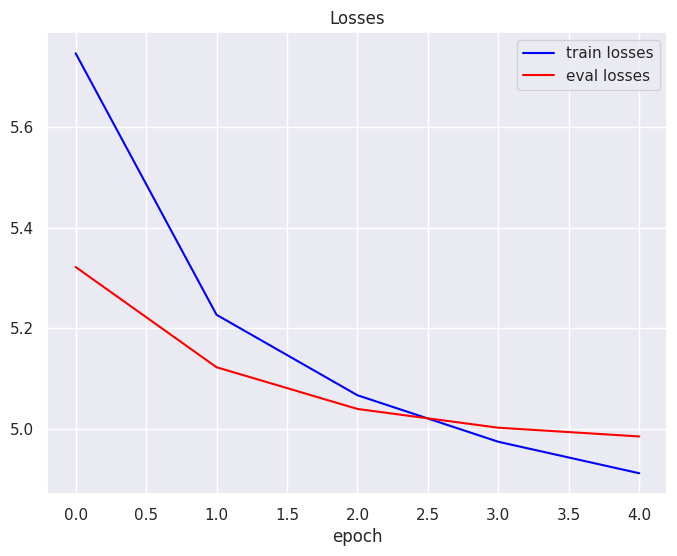

In [41]:
plt.figure(figsize=(8, 6))

eval_losses[name] = [i.cpu() for i in eval_losses[name]]

n_epochs = len(eval_losses[name])
plt.plot(np.arange(n_epochs), train_losses[name], label='train losses', c='blue')
plt.plot(np.arange(n_epochs), eval_losses[name], label='eval losses', c='red')
plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

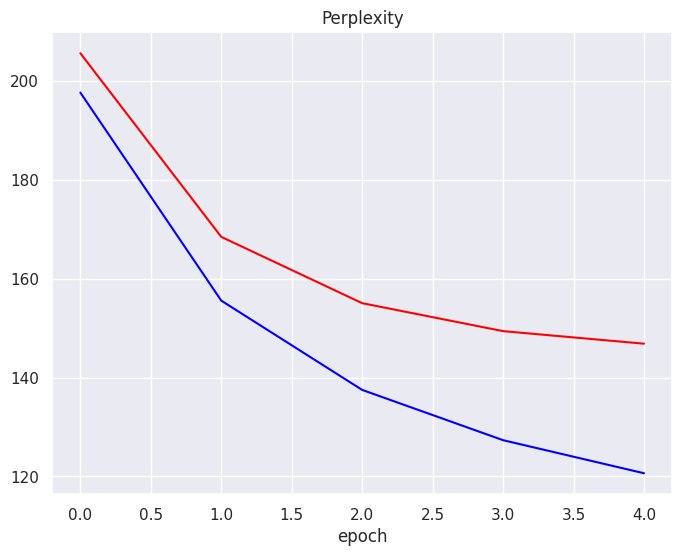

In [42]:
plt.figure(figsize=(8, 6))

n_epochs = len(eval_peprlexities[name])
plt.plot(np.arange(n_epochs), train_peprlexities[name], label='train perplexity', c='blue')
plt.plot(np.arange(n_epochs), eval_peprlexities[name], label='eval perplexity', c='red')
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [43]:
evaluate(model2, criterion, test_dataloader)

(tensor(4.9899, device='cuda:0'), 147.6571825753271)

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

#### **Эксперимент 1 (GRU слой)**

Видно, что модель учится, однако в какой-то момент loss и перплексия на валидационной выборке перестают падать, что свидетельствует о переобучении. Получается относительно высокая перплексия.

#### **Эксперимент 2 (2 LSTM слоя)**

Модель в итоге справилась не намного лучше, достигнув перплексии ~147 на тестовой выборке.

Таблица:

| Эксперимент | Значение loss на test  | Значение перплексии на test  |
|---|---|---|
| №1 - GRU  | 5.04  | 155 |
| №2 - LSTM | 4.99 | 147 |

Общий вывод: думаю, необходимо поменять что-то в предобработке текстов или у меня где-то ошибка. Хотя обе модели и учатся, высоких метрик достигнуть не получается
